# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: BayesianMechanics

Roll number: 2018113001, 2018113002

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [1]:
import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import tqdm.notebook as tqdm

INFO - 2021-09-26 01:53:49,468 - utils - NumExpr defaulting to 8 threads.


# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.
1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?
2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity?
3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.


### Answer 1

All the mentioned transforms are ways of transforming one n-d coordinate system to another.

1. An linear transform is a transform from one vector space to another in which each of the coordinates of the object in the output vector space are a linear combination of the objects in the input vector space. Such transforms can only provide for rotation and scaling. An addition of a constant vector in the output vector space provides for translation. Such a transform, which is a composition of a linear transform and a vector addition is called an **affine transform**. The **colinearity of points** is held as in invariant in such a transform, so any lines continue to stay lines, and parallel lines continue to stay parallel, same for planes. Eigen values here are not preserved.

2. **Similarity transforms** essentially rewriting the basis set of one vector space in terms of other basis vector. Such a transform is **Determinant Preserving, Trace Preserving, Eigen Value Preserving**. Lines and planes stay lines and planes. 

3. A **Euclidean Transform** is a rigid transformation where the distances between all pairs of points are preserved, so the only operations acting are rotation and translation. In such a transform **all shapes are preserved, all structures and curvatures are preserved, and size and scale is preserved**. This is therefore a subclass of affine transforms, where the linear part of the transform is forcefully an orthogonal matrix.

### Answer 2

The points at infinity are of the form:
$$\begin{bmatrix}x\\y\\z\\0\end{bmatrix}$$
The last element being 0 sends the point to infinity.

Inverse Projective Transforms can bring points from infinity back to a non-infinite point. Such transforms will have some of any but last element of the last row being non-zero.

$$\begin{bmatrix}R & R & R & T \\ R & R & R & T \\ R & R & R & T \\ * & * & * & Q\end{bmatrix}$$

If any of the $*$ elements are non-zero, then the matrix brings the points at infinity to real valued points.

### Answer 3

The following is the transformation matrix from the camera frame to the world frame:

$$ (T_3 \times T_2 \times T_1 \times T_4 \times T_5)^{-1} = (T_5^{-1} \times T_4^{-1} \times T_1^{-1} \times T_2^{-1} \times T_3^{-1}) $$

# Visualise the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format - x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualise for 1-2 frames.

In [2]:
pcd_list = []
for filename in tqdm.tqdm(sorted(os.listdir("data/LiDAR"))):
    pcd = np.fromfile(f"data/LiDAR/{filename}", dtype=np.float32)
    pcd = pcd.reshape((-1, 4))[:, 0:3]
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd))
    pcd_list.append(pcd)

In [3]:
transform_lidar_to_camera = np.array([
    [  0, -1,  0,  0],
    [  0,  0, -1,  0],
    [  1,  0,  0,  0],
    [  0,  0,  0,  1]
])

with open('data/odometry.txt', 'r') as f:
    pose_list = []
    for transform in f.readlines()[:77]:
        transform = list(map(float, transform.strip().split()))
        transform = np.array(transform).reshape(3, 4)
        transform = np.vstack([transform, np.array([[0, 0, 0, 1]])])
        transform = transform @ transform_lidar_to_camera
        pose_list.append(transform)
    pose_list = np.stack(pose_list, axis=0)

In [4]:
for pcd in pcd_list[:4]:
    o3d.visualization.draw_geometries([pcd], front=[0, 0, 1], up=[0, 1, 0], zoom=1, lookat=[0, 0, 0])

# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

![Transform Image](./img/transform.png)

### Answer 1

In [5]:
def invert_pose(pose):
    rot = pose[:3, :3].T
    trans = (-pose[:3, 3]).reshape(-1, 1)
    return np.vstack([np.hstack([rot, trans]),
                      np.array([[0, 0, 0, 1]])])

In [6]:
transformed_list = []
for pcd, pose in zip(pcd_list, pose_list):
    # TODO: Figure out if we should use pose or inverse pose
    transformed_list.append(copy.deepcopy(pcd).transform(pose))

### Answer 2

In [7]:
superposed_cloud = o3d.geometry.PointCloud()
for cloud in transformed_list:
    superposed_cloud += cloud

In [8]:
o3d.visualization.draw_geometries([superposed_cloud])

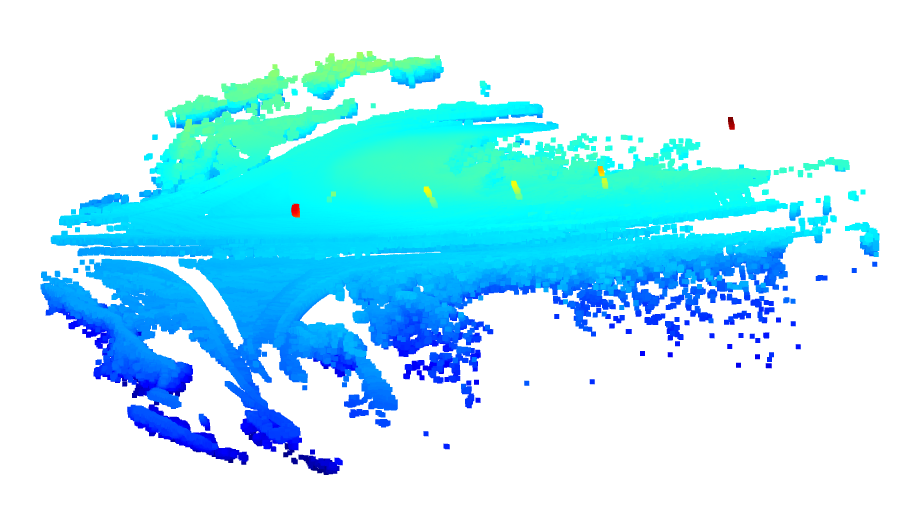

### Answer 3

In [9]:
def pcd_in_frame(frame_idx):
    return copy.deepcopy(superposed_cloud).transform(np.linalg.inv(pose_list[frame_idx]))

### Answer 4

In [10]:
# Initialization of the Window and Objects
win = o3d.visualization.Visualizer()
win.create_window()

# Rotations in the locked position

last_pose = np.eye(4)
for i in tqdm.trange(77):
    pcd = pcd_in_frame(i)
    win.add_geometry(pcd)
    win.poll_events()
    win.update_renderer()        
    win.remove_geometry(pcd)

win.destroy_window()

# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

In [11]:
def occupancy_map(cloud, resolution=1, use_tqdm=False):
    points = (np.asarray(cloud.points) * resolution).astype(int)
    bot, top = np.min(points, axis=0), np.max(points, axis=0)
    occupancy = np.zeros(shape=(top - bot + 1))
    points = points - bot
    iterator = tqdm.tqdm(points) if use_tqdm else points
    for point in iterator:
        occupancy[point[0], point[1], point[2]] += 1
    return occupancy
    
oc_map = occupancy_map(superposed_cloud, use_tqdm=True)

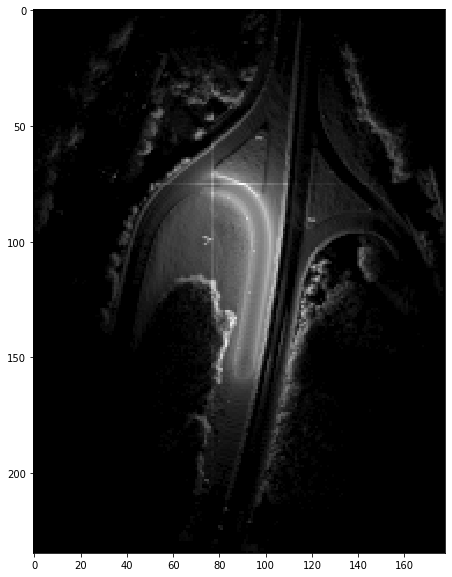

In [12]:
planar_map = np.sum(oc_map, axis=1) ** 0.4
plt.figure(figsize=(10, 10))
plt.imshow(planar_map, cmap='gray')
plt.show()

### Answer 1 and 2

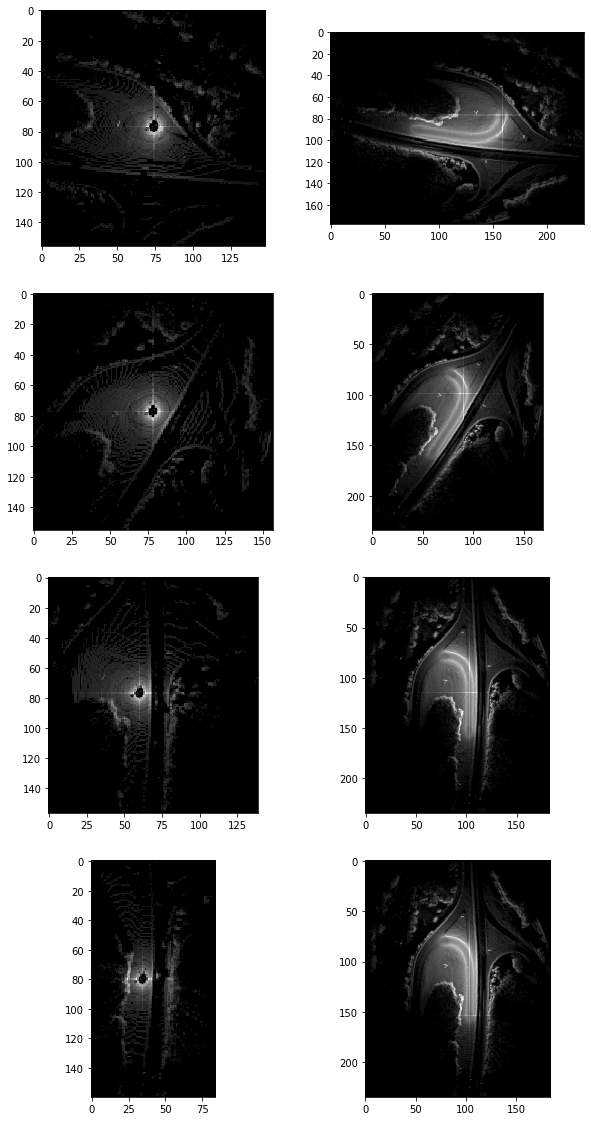

In [13]:
samples = [0, 25, 50, 75]
fig, ax = plt.subplots(len(samples), 2, figsize=(10, 5 * len(samples)))
for i, val_i in enumerate(samples):
    oc_org_map = occupancy_map(pcd_list[val_i], use_tqdm=True)
    oc_frame_map = occupancy_map(pcd_in_frame(val_i), use_tqdm=True)
    ax[i][0].imshow(np.sum(oc_org_map, axis=2) ** 0.4, cmap='gray')
    ax[i][1].imshow(np.sum(oc_frame_map, axis=2) ** 0.4, cmap='gray')
plt.show()

### Comparative

The images show that the full point cloud has a lot more detail and more coverage than the individual LiDAR images.